In [1]:
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.utils.data import DataLoader

from score_models.trainer import trainer
from score_models.models.mlp import MLPScoreModel
from score_models.train_steps import TrainStepNCSN
from score_models.utils.data import guassian_mixture
from score_models.utils.noise import get_sigmas
from score_models.utils.visualisations import plot_gradient_field
from score_models.sampling import annealed_langevin_dynamics

In [2]:
# load dataset
dataset = guassian_mixture(N=10_000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [3]:
device = "cuda"
input_size = 2
hidden_size = 32
L = 10
lr = 1e-4

# define score model and optimizer
score_model = MLPScoreModel(input_size=input_size, hidden_size=hidden_size, T=L).to(device)
optimizer = optim.Adam(score_model.parameters(), lr=lr)

# define train step (i.e., criterion)
sigma_min, sigma_max = 1.0, 20.0
sigmas = get_sigmas(L=L, sigma_min=sigma_min, sigma_max=sigma_max)
train_step = TrainStepNCSN(score_model=score_model, sigmas=sigmas)


In [4]:
score_model = trainer(
    train_step=train_step,
    model=score_model,
    train_loader=dataloader,
    optimizer=optimizer,
    device=device,
    num_steps=20000,
    log_every=1000,
    save_every=5000,
)

  5%|▌         | 1034/20000 [00:04<01:06, 284.03it/s]

Step 1000, Loss: 0.9831


 10%|█         | 2060/20000 [00:07<00:55, 322.98it/s]

Step 2000, Loss: 0.9037


 15%|█▌        | 3060/20000 [00:10<00:55, 304.67it/s]

Step 3000, Loss: 0.8078


 20%|██        | 4053/20000 [00:13<00:52, 305.37it/s]

Step 4000, Loss: 0.7401


 25%|██▌       | 5044/20000 [00:17<00:51, 292.16it/s]

Step 5000, Loss: 0.6716


 30%|███       | 6054/20000 [00:20<00:49, 280.78it/s]

Step 6000, Loss: 0.6120


 35%|███▌      | 7032/20000 [00:24<00:46, 278.46it/s]

Step 7000, Loss: 0.6685


 40%|████      | 8043/20000 [00:27<00:40, 291.70it/s]

Step 8000, Loss: 0.6021


 45%|████▌     | 9055/20000 [00:31<00:35, 307.29it/s]

Step 9000, Loss: 0.5819


 50%|█████     | 10056/20000 [00:34<00:34, 286.45it/s]

Step 10000, Loss: 0.5520


 55%|█████▌    | 11043/20000 [00:38<00:31, 287.52it/s]

Step 11000, Loss: 0.5998


 60%|██████    | 12044/20000 [00:41<00:28, 281.41it/s]

Step 12000, Loss: 0.5330


 65%|██████▌   | 13056/20000 [00:45<00:24, 285.17it/s]

Step 13000, Loss: 0.5645


 70%|███████   | 14054/20000 [00:48<00:20, 286.03it/s]

Step 14000, Loss: 0.4993


 75%|███████▌  | 15028/20000 [00:52<00:17, 285.38it/s]

Step 15000, Loss: 0.5290


 80%|████████  | 16041/20000 [00:55<00:13, 295.34it/s]

Step 16000, Loss: 0.5414


 85%|████████▌ | 17032/20000 [00:58<00:09, 311.88it/s]

Step 17000, Loss: 0.5211


 90%|█████████ | 18055/20000 [01:02<00:06, 284.38it/s]

Step 18000, Loss: 0.5386


 95%|█████████▌| 19057/20000 [01:05<00:03, 298.82it/s]

Step 19000, Loss: 0.5498


100%|██████████| 20000/20000 [01:08<00:00, 289.92it/s]

Step 20000, Loss: 0.5481


In [5]:
# sample some datapoints
samples = annealed_langevin_dynamics(
    score_model=score_model, 
    input_size=(500, 2), 
    sigmas=sigmas, 
    r=(-8, 8), 
    T=100,
    eps=0.1,
).cpu().numpy()

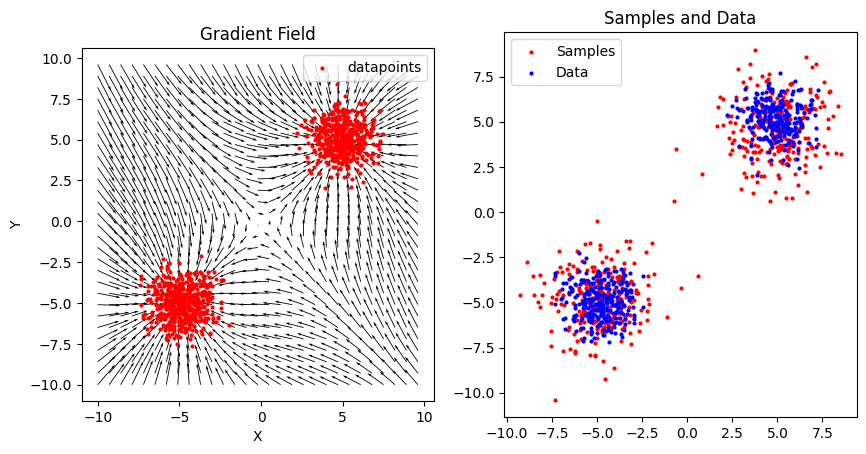

In [9]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plot gradient field
plot_gradient_field(score_model=score_model, i=L-1, datapoints=dataset[:1000], ax=ax[0])

# plot original data and samples
ax[1].scatter(samples[:, 0], samples[:, 1], color='red', s=4, label='Samples')
ax[1].scatter(dataset[:500][:, 0], dataset[:500][:, 1], color='blue', s=4, label='Data')
ax[1].set_title('Samples and Data')
plt.legend();